In [1]:
from fastai.vision import *
from fastai.vision.data import *
import numpy as np 
import pandas as pd
import tensorflow as tf 
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [2]:
from fastai.widgets import *

In [3]:
labels = ['0','1','2','3','4','5']
classes = labels

In [4]:
path = "train_data"
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5,max_rotate = 15)
data = (ImageList.from_csv(path, csv_name = 'train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'data_test')              
        .transform(tfms, size=128)
        .databunch(num_workers=0))
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
4,5,4,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
5,0,4,0,5
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data

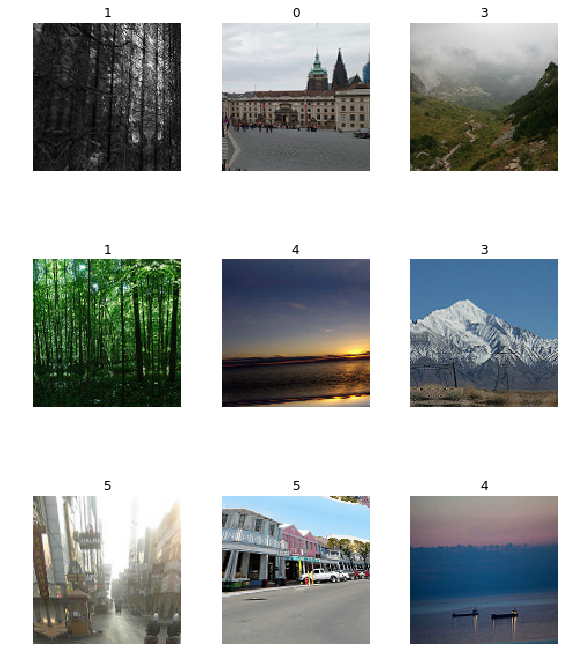

In [15]:
data.show_batch(rows=3, figsize=(8,10))

In [5]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [4]:
learn = create_cnn(data,models.resnet50,metrics=[error_rate, accuracy])

c:\users\rohit\virtualenv\lib\site-packages\fastai\vision\learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [5]:
learn.fit_one_cycle(8)

In [6]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

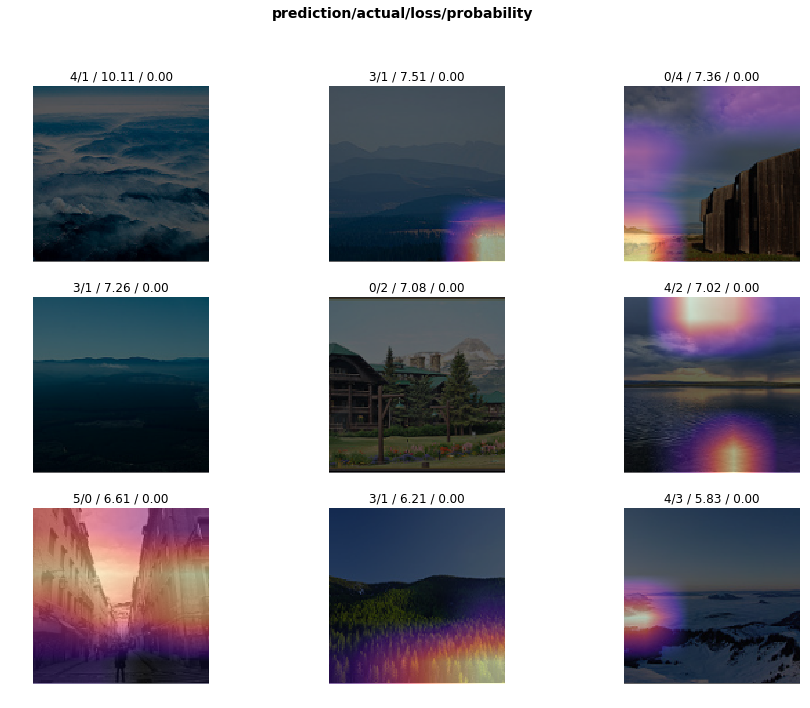

In [7]:
interp.plot_top_losses(9, figsize=(15,11))

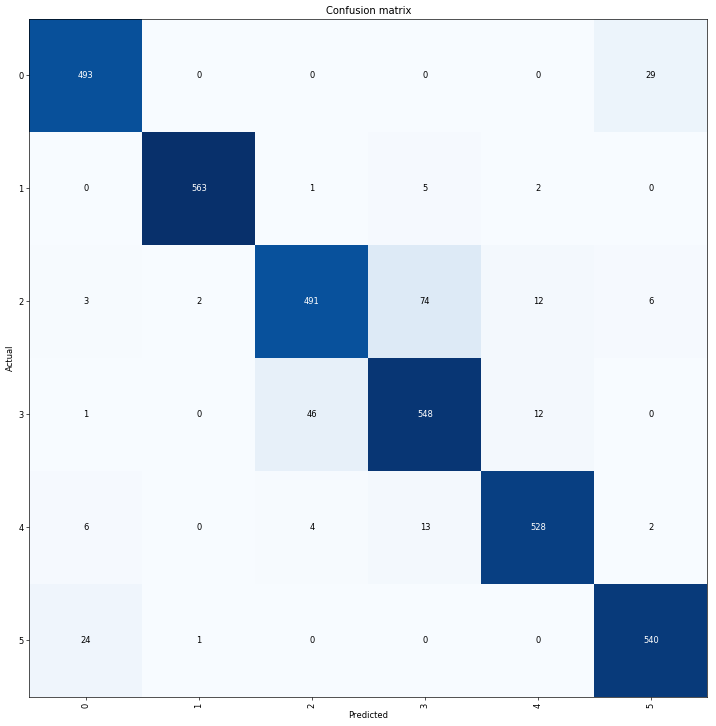

In [8]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [9]:
interp.most_confused(min_val=5)

[(2, 3, 74),
 (3, 2, 46),
 (0, 5, 29),
 (5, 0, 24),
 (4, 3, 13),
 (2, 4, 12),
 (3, 4, 12),
 (2, 5, 6),
 (4, 0, 6),
 (1, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


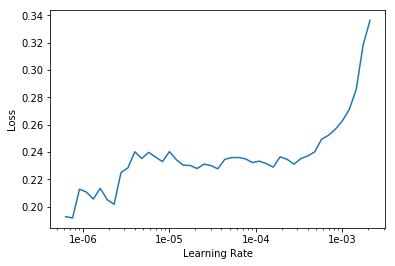

In [10]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.save('stage1-resnet50-normal')

# Stage 2

In [5]:
learn.load('stage1-resnet50-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,2,2,4,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [6]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,5e-6))

In [7]:
learn.save('stage2-resnet50-normal')

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

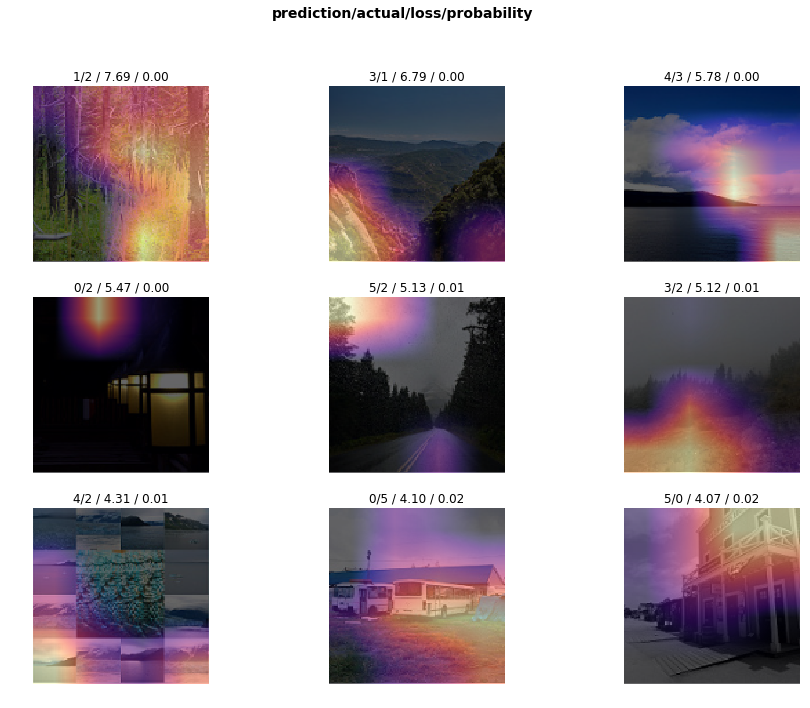

In [9]:
interp.plot_top_losses(9, figsize=(15,11))

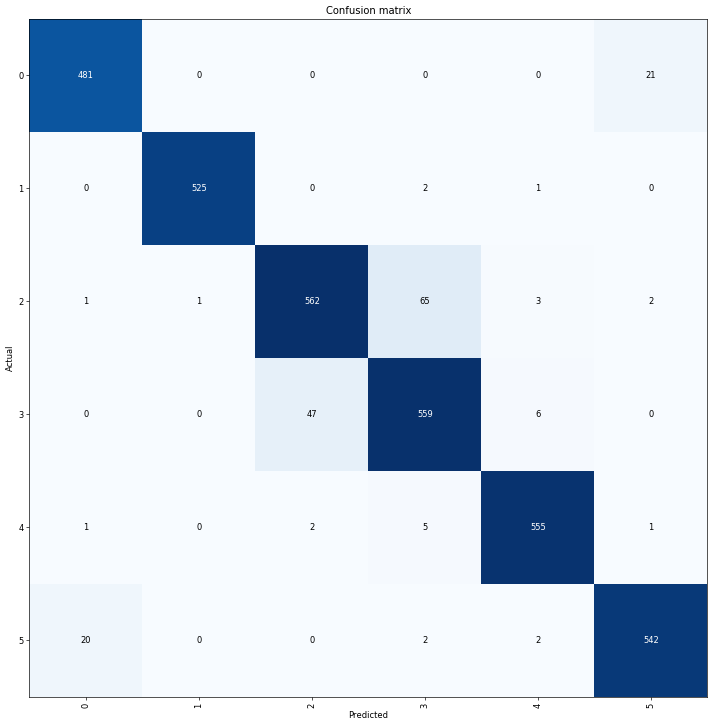

In [10]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=5)

[(2, 3, 65), (3, 2, 47), (0, 5, 21), (5, 0, 20), (3, 4, 6), (4, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


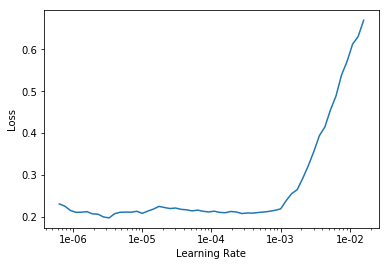

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
import gc 
gc.collect()

6382

In [16]:
path='train-scene/train'
test = pd.read_csv('test.csv')

In [17]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      5     0.999467
1      5.jpg      0     0.999785
2      6.jpg      4     0.999918
3     11.jpg      2     0.788692
4     14.jpg      5     0.983365

In [18]:
uncertain = answer.loc[answer['probability']<0.5].count()
print(uncertain)

image_name     50
label          50
probability    50
dtype: int64


In [19]:
answer.to_csv('stage2_resnet50_normal.csv')

# Stage 3

In [5]:
learn.load('stage2-resnet50-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,4
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
2,5,1,5,4
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [6]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

In [7]:
learn.save('stage3-resnet50-normal')

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

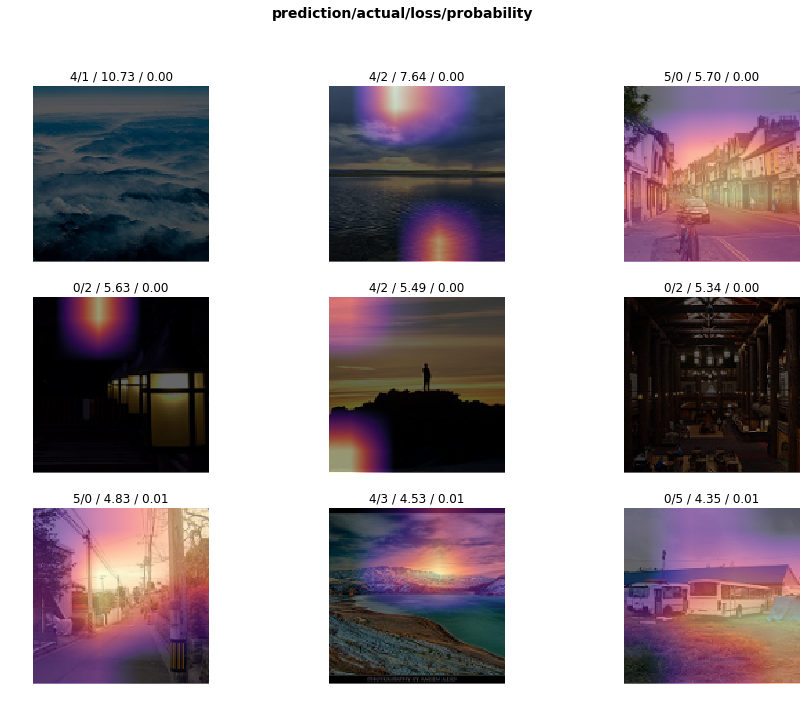

In [9]:
interp.plot_top_losses(9, figsize=(15,11))

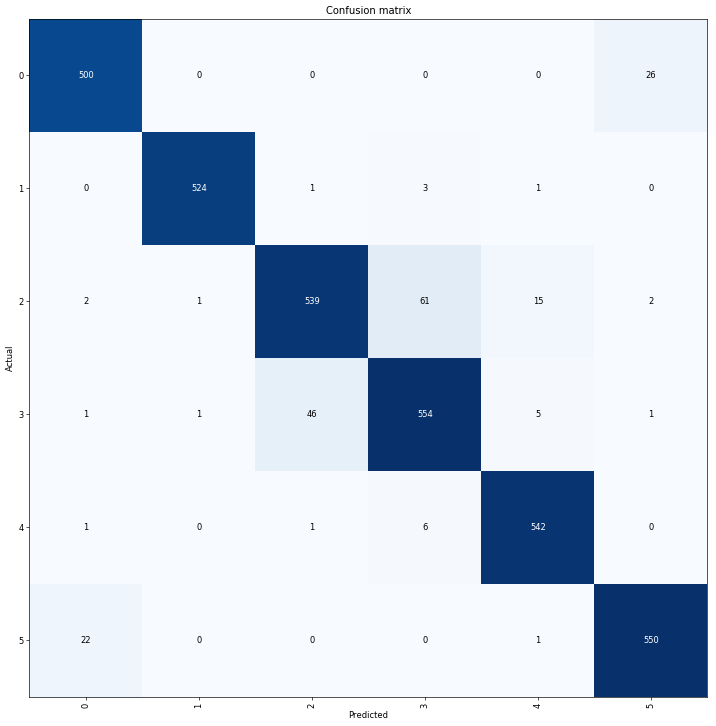

In [10]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=5)

[(2, 3, 61),
 (3, 2, 46),
 (0, 5, 26),
 (5, 0, 22),
 (2, 4, 15),
 (4, 3, 6),
 (3, 4, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


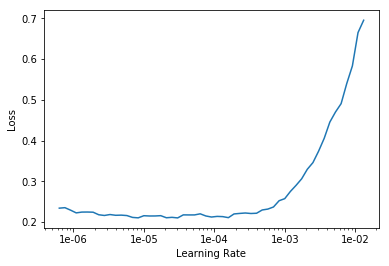

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
path = 'train-scene/train'
print(path)

train-scene/train


In [14]:
test = pd.read_csv('test.csv')

In [15]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
answer.to_csv('stage3_resnet50_normal.csv')

In [16]:
import gc
gc.collect()

6455

In [17]:
answer.head()

image_name  label  probability
0      3.jpg      5     0.999556
1      5.jpg      0     0.999723
2      6.jpg      4     0.999915
3     11.jpg      2     0.743482
4     14.jpg      5     0.985260

In [18]:
answer.probability.sum() / answer.probability.count()

0.9370658669124285

In [19]:
uncertain = answer.loc[answer['probability']<0.5]
uncertain.count()

image_name     54
label          54
probability    54
dtype: int64

# Stage 4

In [54]:
learn.fit_one_cycle(5, max_lr=slice(1e-6))

In [55]:
learn.save('stage4')

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

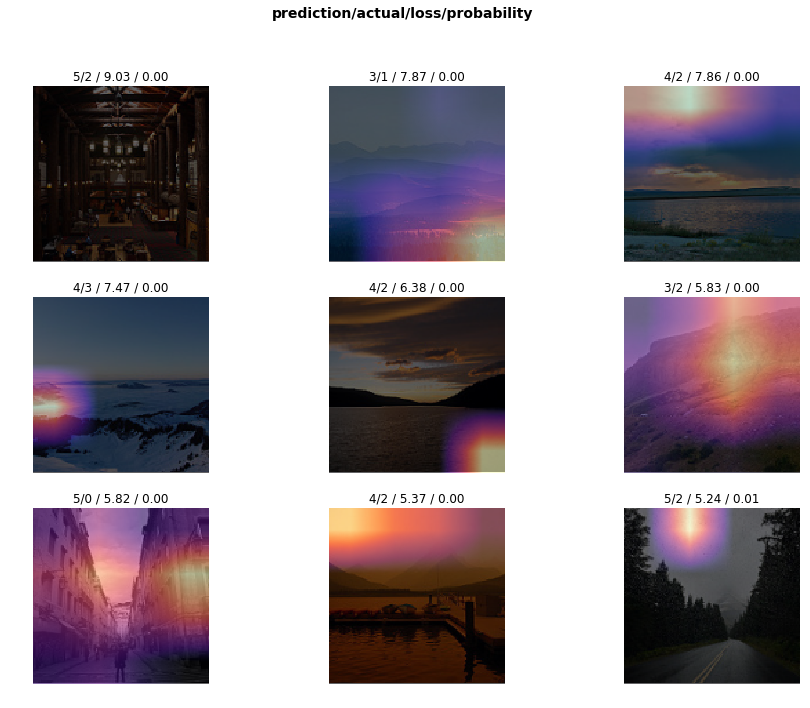

In [58]:
interp.plot_top_losses(9, figsize=(15,11))

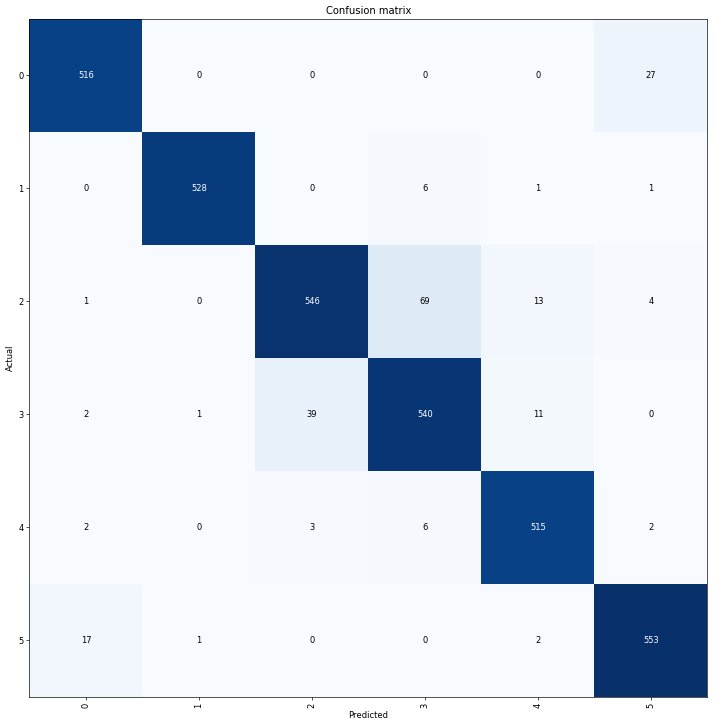

In [59]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [60]:
interp.most_confused(min_val=5)

[(2, 3, 69),
 (3, 2, 39),
 (0, 5, 27),
 (5, 0, 17),
 (2, 4, 13),
 (3, 4, 11),
 (1, 3, 6),
 (4, 3, 6)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


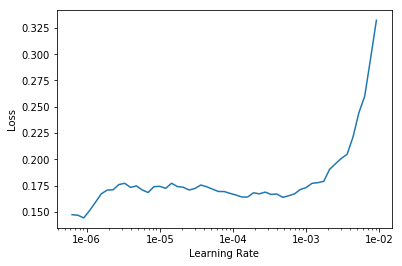

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [61]:
path = 'train-scene/train'
print(path)

train-scene/train


In [62]:
test = pd.read_csv('test.csv')

In [63]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
answer.to_csv('submission.csv')

In [64]:
import gc
gc.collect()

18295

# Densenet

In [1]:
from fastai.vision import *

In [2]:
path = "train_data"
tfms = get_transforms(flip_vert=False,max_zoom=1.1,max_warp=0.5,max_lighting=0.3,p_lighting = 0.5 )
data = (ImageList.from_csv(path, csv_name = 'train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'data_test')              
        .transform(tfms, size=128)
        .databunch(num_workers=0))

In [3]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,0,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,1,3
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data

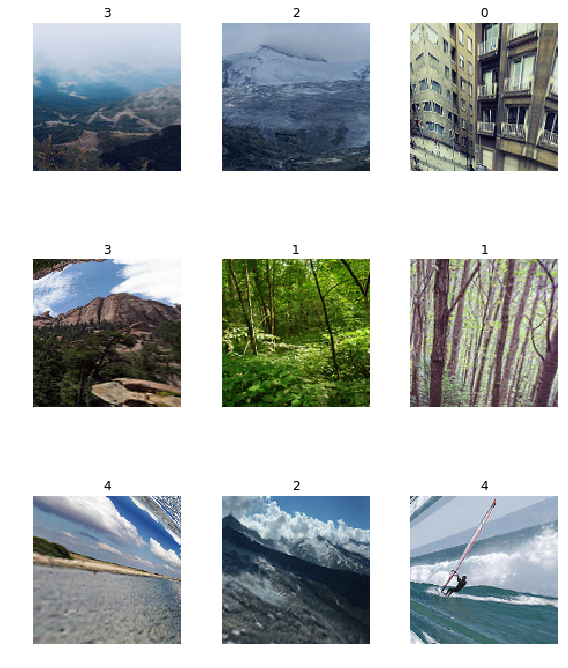

In [4]:
data.show_batch(rows=3, figsize=(8,10))

In [5]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [6]:
learn = cnn_learner(data,models.densenet121,metrics=[error_rate, accuracy])

c:\users\rohit\virtualenv\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [7]:
learn.fit_one_cycle(5)

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

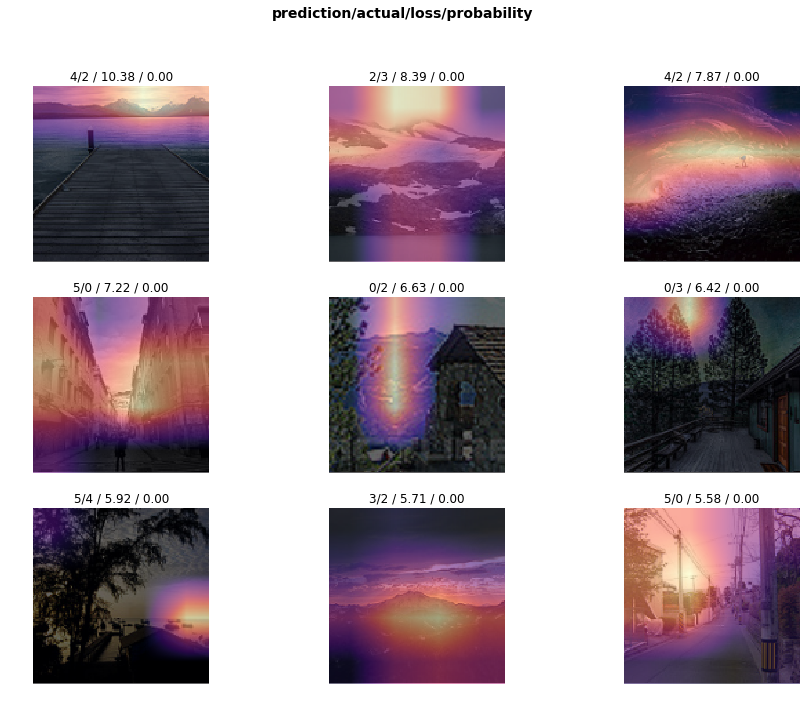

In [9]:
interp.plot_top_losses(9, figsize=(15,11))

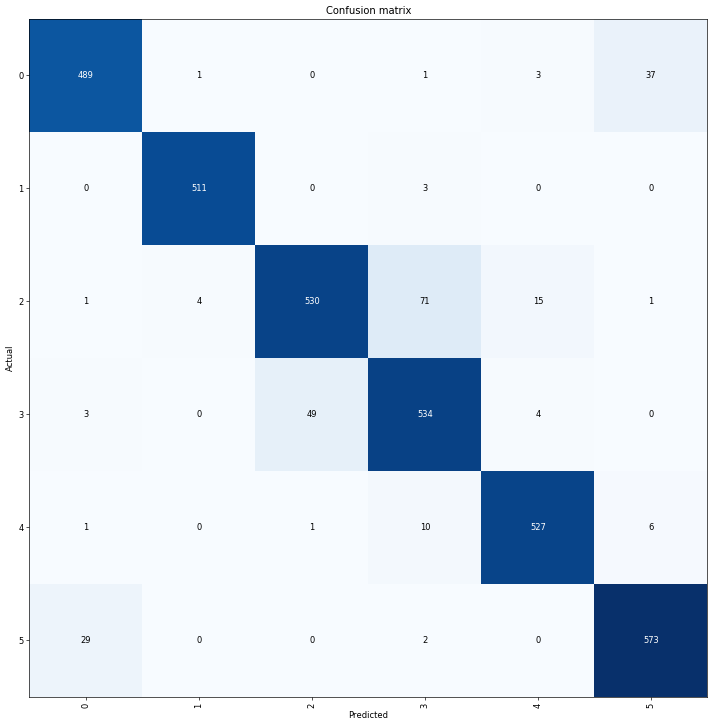

In [10]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=5)

[(2, 3, 71),
 (3, 2, 49),
 (0, 5, 37),
 (5, 0, 29),
 (2, 4, 15),
 (4, 3, 10),
 (4, 5, 6)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


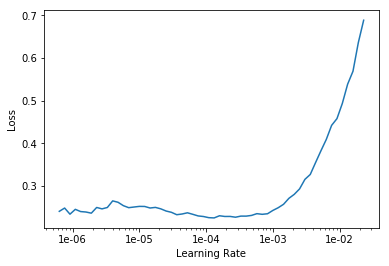

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.save('stage1-densenet-normal')

In [14]:
import gc 
gc.collect()

6380

# Stage 2

In [15]:
learn.load('stage1-densenet-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,0,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,1,3
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [16]:
learn.fit_one_cycle(10,max_lr = slice(1e-6,5e-4))

In [17]:
learn.save('stage2-densenet-normal')

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

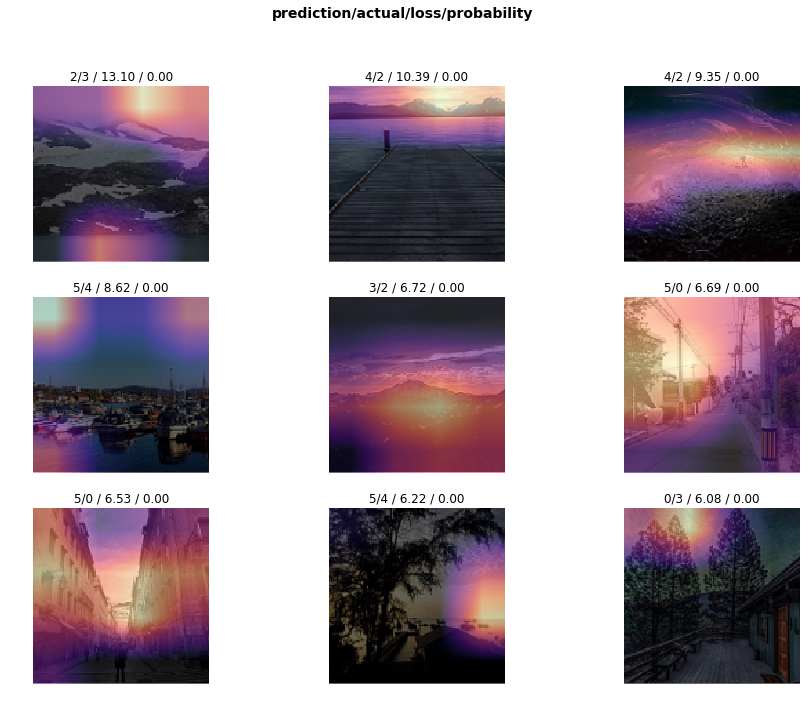

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

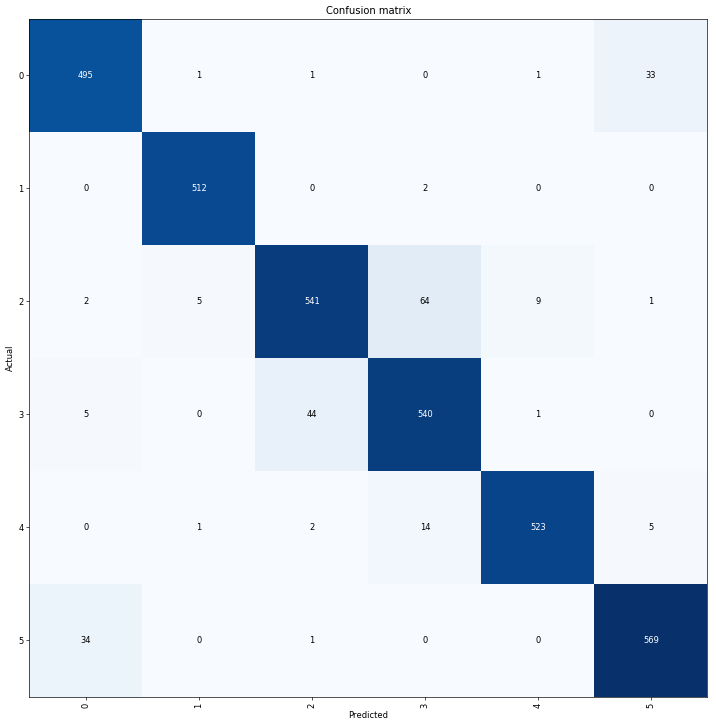

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=5)

[(2, 3, 64),
 (3, 2, 44),
 (5, 0, 34),
 (0, 5, 33),
 (4, 3, 14),
 (2, 4, 9),
 (2, 1, 5),
 (3, 0, 5),
 (4, 5, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


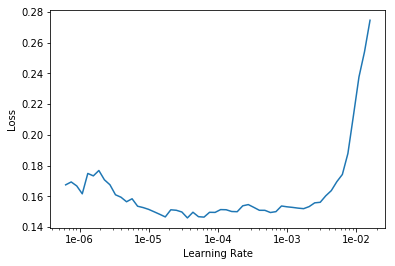

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
test = pd.read_csv('test.csv')

In [24]:
import gc 
gc.collect()

6555

In [25]:
path='train-scene/train'

In [26]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      5     0.999989
1      5.jpg      0     0.999658
2      6.jpg      4     0.999670
3     11.jpg      2     0.529248
4     14.jpg      5     0.999362

In [27]:
uncertain = answer.loc[answer['probability']<0.5].count()
print(uncertain)

image_name     28
label          28
probability    28
dtype: int64


In [28]:
answer.to_csv('stage2_densenet_normal.csv')

# Stage 3

In [22]:
learn.load('stage2-densenet_normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,4
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,5,2,5,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [23]:
learn.fit_one_cycle(5,max_lr = slice(3e-5,9e-5))

In [24]:
learn.save('stage-3-densenet')

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

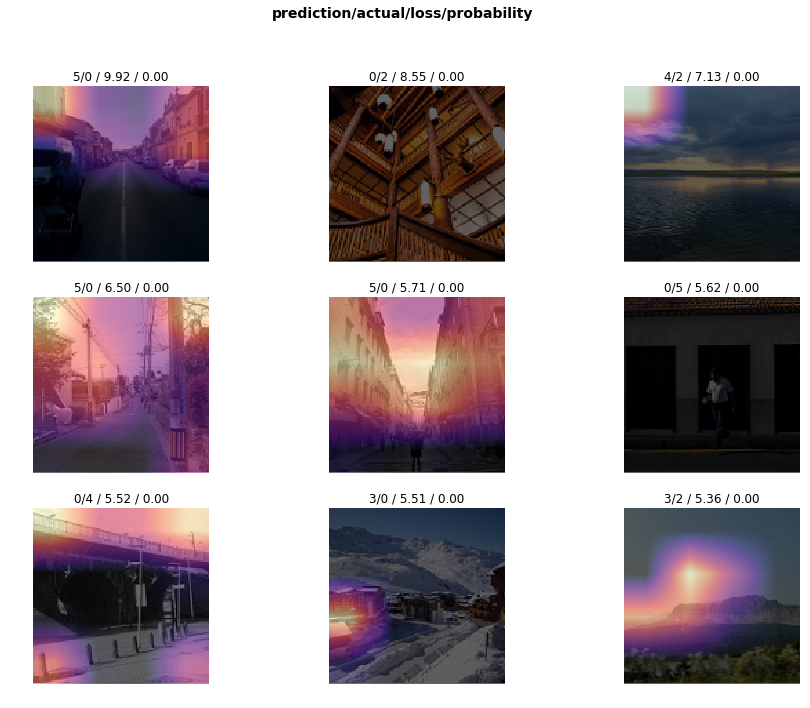

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

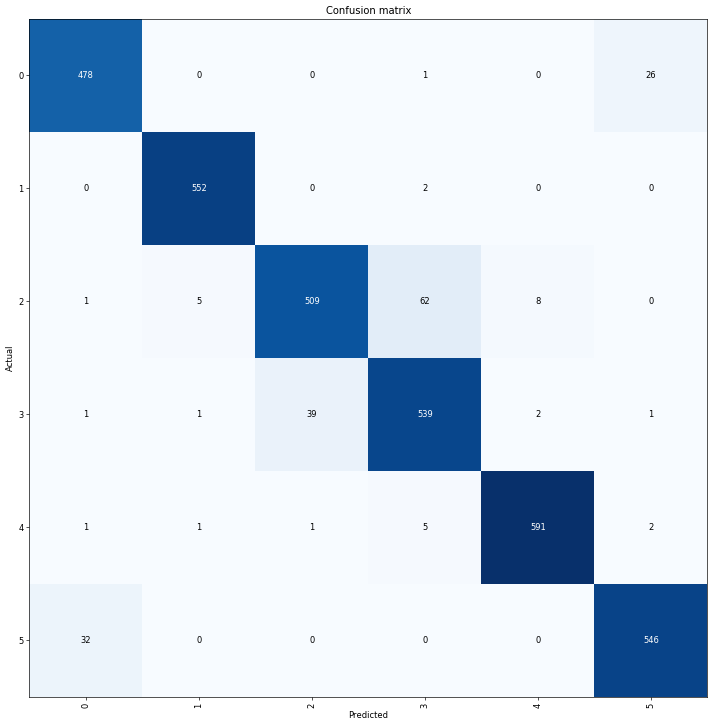

In [29]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
interp.most_confused(min_val=5)

[(2, 3, 62),
 (3, 2, 39),
 (5, 0, 32),
 (0, 5, 26),
 (2, 4, 8),
 (2, 1, 5),
 (4, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


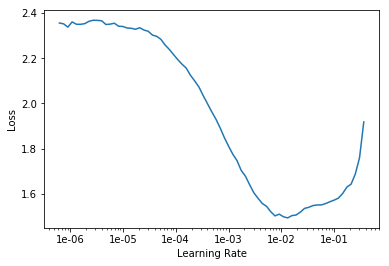

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
test = pd.read_csv('test.csv')

In [33]:
import gc 
gc.collect()

6974

In [34]:
path='train-scene/train'

In [35]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      2     0.287165
1      5.jpg      5     0.331877
2      6.jpg      5     0.273970
3     11.jpg      2     0.376281
4     14.jpg      2     0.576744

In [36]:
uncertain = answer.loc[answer['probability']<0.5].count()
print(uncertain)

image_name     6860
label          6860
probability    6860
dtype: int64


In [37]:
answer.to_csv('stage3_densenet.csv')

# ResNet152 Normalized

In [1]:
from fastai.vision import *

In [2]:
path = "train_data"
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5)
data = (ImageList.from_csv(path, csv_name = 'train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'data_test')              
        .transform(tfms, size=224)
        .databunch(num_workers=0))

In [3]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,4,0,4,1
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,5,4,3,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data

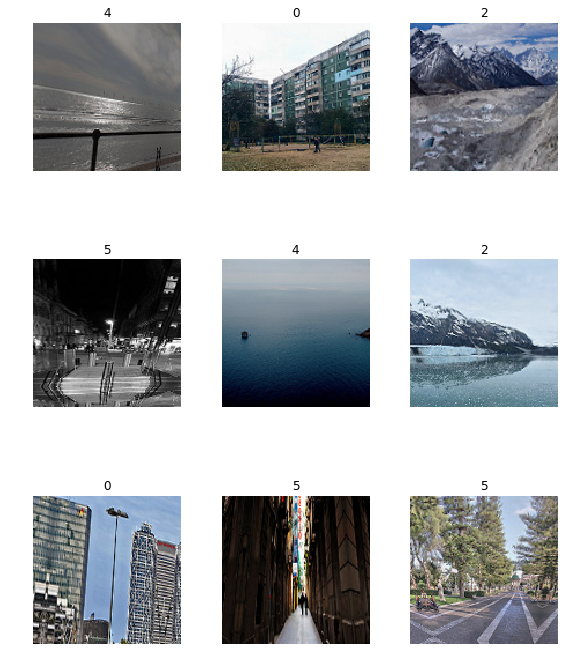

In [41]:
data.show_batch(rows=3, figsize=(8,10))

In [42]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [5]:
learn = cnn_learner(data,models.resnet152,metrics=[error_rate, accuracy])

In [17]:
learn.fit_one_cycle(8)

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [19]:
learn.save('stage1-resnet152-normal-rotate')

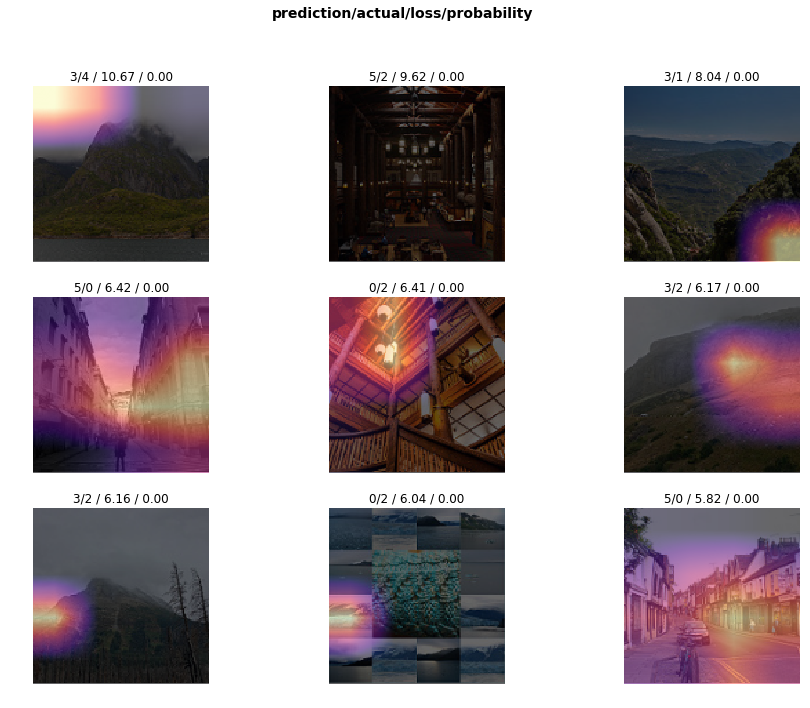

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

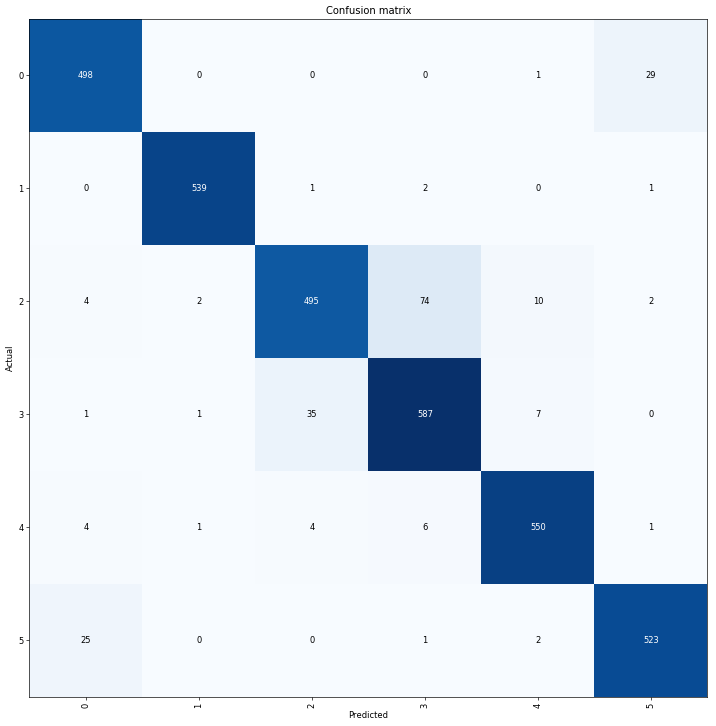

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=5)

[(2, 3, 74),
 (3, 2, 35),
 (0, 5, 29),
 (5, 0, 25),
 (2, 4, 10),
 (3, 4, 7),
 (4, 3, 6)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


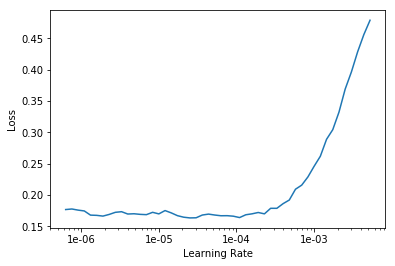

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
#learn.save('stage1-resnet152-normal')

In [25]:
import gc 
gc.collect()

6002

# Stage 2

In [26]:
learn.load('stage1-resnet152-normal-rotate')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,5,0,4,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
4,3,0,5,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [27]:
learn.fit_one_cycle(10,max_lr = slice(1e-6,1e-4))

In [28]:
learn.save('stage-2-resnet152-normal-rotate')

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

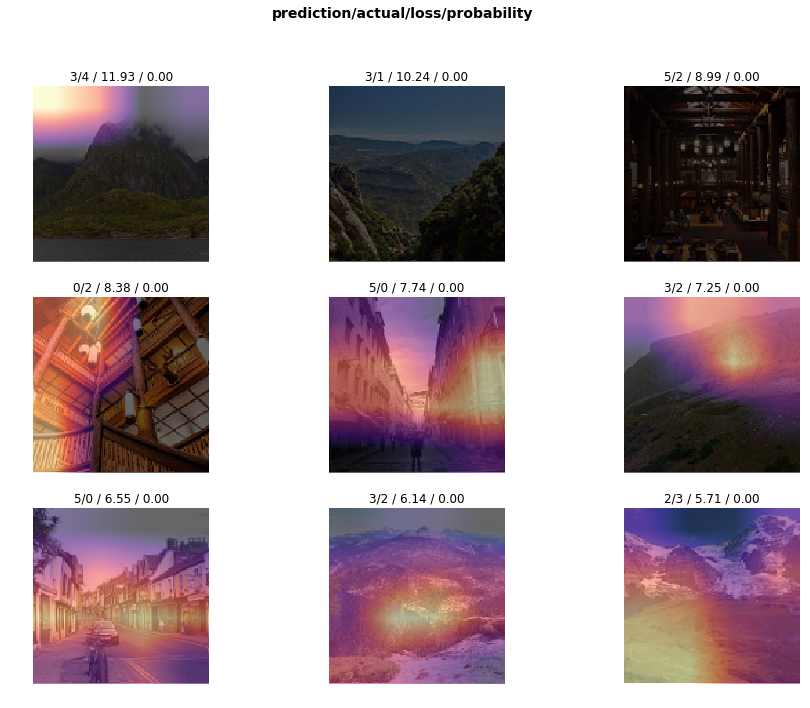

In [30]:
interp.plot_top_losses(9, figsize=(15,11))

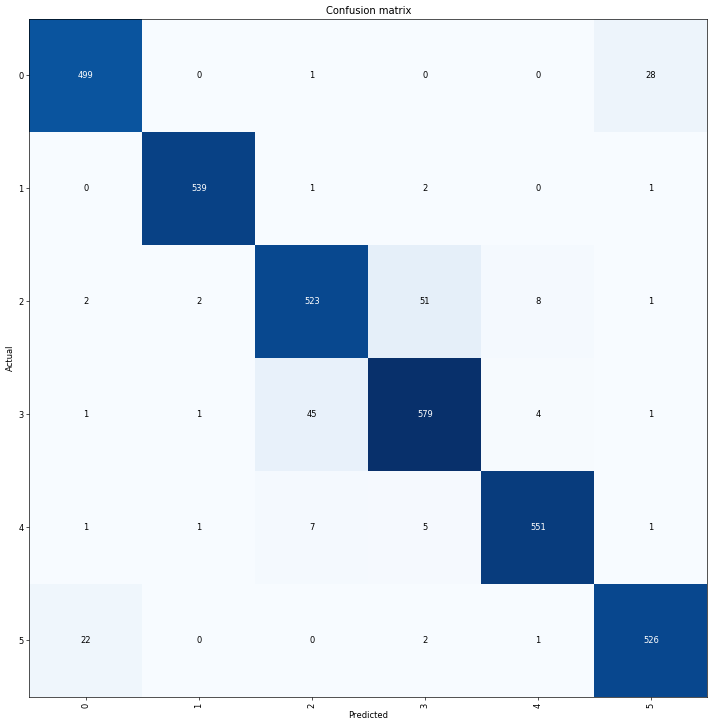

In [31]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [32]:
interp.most_confused(min_val=5)

[(2, 3, 51),
 (3, 2, 45),
 (0, 5, 28),
 (5, 0, 22),
 (2, 4, 8),
 (4, 2, 7),
 (4, 3, 5)]

In [7]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 8.00 GiB total capacity; 6.06 GiB already allocated; 1.47 MiB free; 62.89 MiB cached)

In [6]:
learn.load('stage-2-resnet152-normal-rotate')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
4,5,4,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
5,0,4,0,5
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [7]:
test = pd.read_csv('test.csv')

In [8]:
import gc 
gc.collect()

0

In [9]:
path='train-scene/train'

In [10]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      5     0.999885
1      5.jpg      0     0.996232
2      6.jpg      4     0.999616
3     11.jpg      4     0.692510
4     14.jpg      5     0.998059

In [11]:
uncertain = answer.loc[answer['probability']<0.5]
print(uncertain)

     image_name  label  probability
113     393.jpg      1     0.363244
493    1634.jpg      2     0.477030
738    2483.jpg      5     0.437503
1028   3508.jpg      3     0.440011
1151   3947.jpg      2     0.390634
2162   7219.jpg      5     0.409379
2457   8135.jpg      0     0.358818
2762   9165.jpg      3     0.492966
2857   9452.jpg      1     0.443902
3230  10769.jpg      0     0.454804
3354  11175.jpg      0     0.472816
3405  11397.jpg      0     0.446411
3715  12461.jpg      4     0.499643
4009  13447.jpg      3     0.400732
4124  13807.jpg      1     0.360525
5091  17023.jpg      2     0.443777
5318  17710.jpg      2     0.439337
5391  17976.jpg      1     0.457644
5574  18616.jpg      1     0.497119
5669  18956.jpg      0     0.495491
6166  20542.jpg      3     0.391633
7058  23539.jpg      4     0.297049
7155  23839.jpg      3     0.457187


In [12]:
uncertain_count = answer.loc[answer['probability']<0.5].count()
print(uncertain_count)

image_name     23
label          23
probability    23
dtype: int64


In [13]:
answer.to_csv('stage2_resnet152_normal_rotate.csv')

# Cleaning the data (doesn't work) 

In [6]:
learn.load('stage-2-resnet152-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,4,0,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,3,5,0,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [6]:
import gc
gc.collect()

0

In [7]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [10]:
#from fastai.widgets import *


In [11]:
#ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [12]:
#ImageCleaner(ds, idxs, path)

# Changing Transforms - ResNet34

In [15]:
tfms = get_transforms(do_flip=True, max_rotate=10,max_zoom=1.0,max_warp=0.2,p_affine=0.75,max_lighting=0.2,p_lighting=0.75)

In [17]:
path = "train_data"
data = (ImageList.from_csv(path, csv_name = 'train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'data_test')              
        .transform(tfms, size=96)
        .databunch(num_workers=0))

In [18]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,4,1,5,2
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
3,4,4,3,0
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data

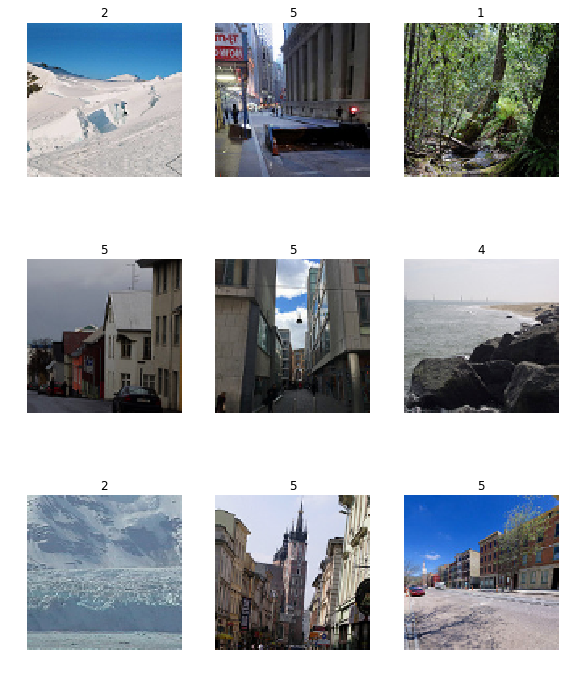

In [19]:
data.show_batch(rows=3, figsize=(8,10))

In [20]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [22]:
learn = cnn_learner(data,models.resnet34,metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\rohit/.torch\models\resnet34-333f7ec4.pth
87306240it [00:37, 2343701.90it/s]


In [23]:
learn.fit_one_cycle(4)

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [25]:
learn.save('stage1-resnet34-normal-rotate')

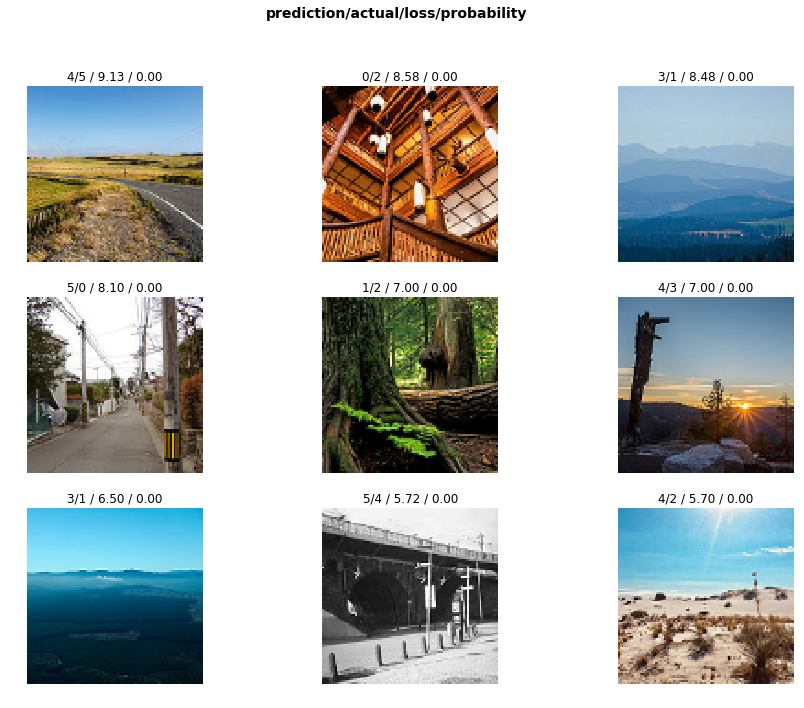

In [26]:
interp.plot_top_losses(9, figsize=(15,11))

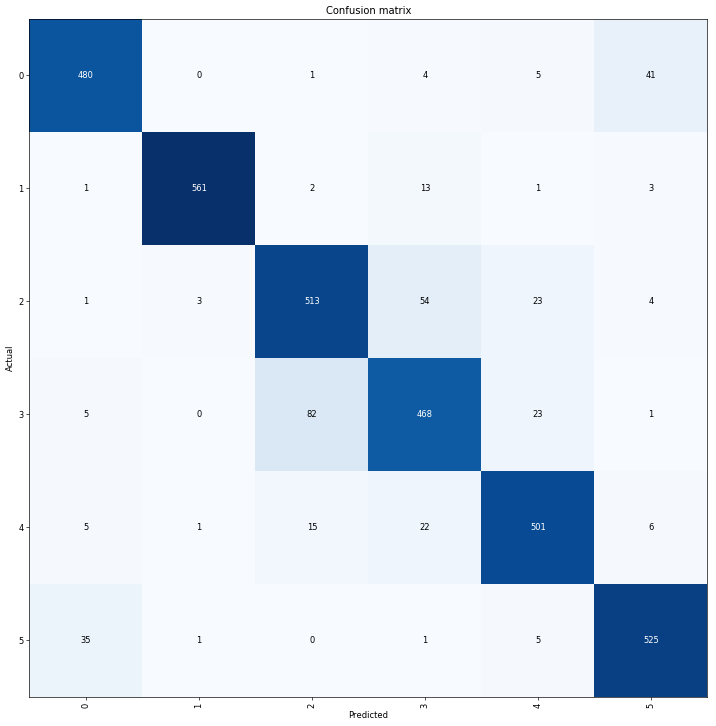

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [28]:
interp.most_confused(min_val=5)

[(3, 2, 82),
 (2, 3, 54),
 (0, 5, 41),
 (5, 0, 35),
 (2, 4, 23),
 (3, 4, 23),
 (4, 3, 22),
 (4, 2, 15),
 (1, 3, 13),
 (4, 5, 6),
 (0, 4, 5),
 (3, 0, 5),
 (4, 0, 5),
 (5, 4, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


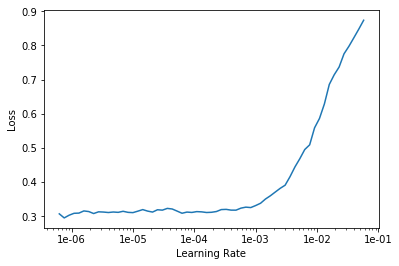

In [29]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
#learn.save('stage1-resnet152-normal')

In [16]:
import gc 
gc.collect()

0

# Stage 2

In [30]:
learn.fit_one_cycle(8,max_lr=slice(1e-6,5e-4))

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [31]:
learn.save('stage1-resnet34-normal-rotate')

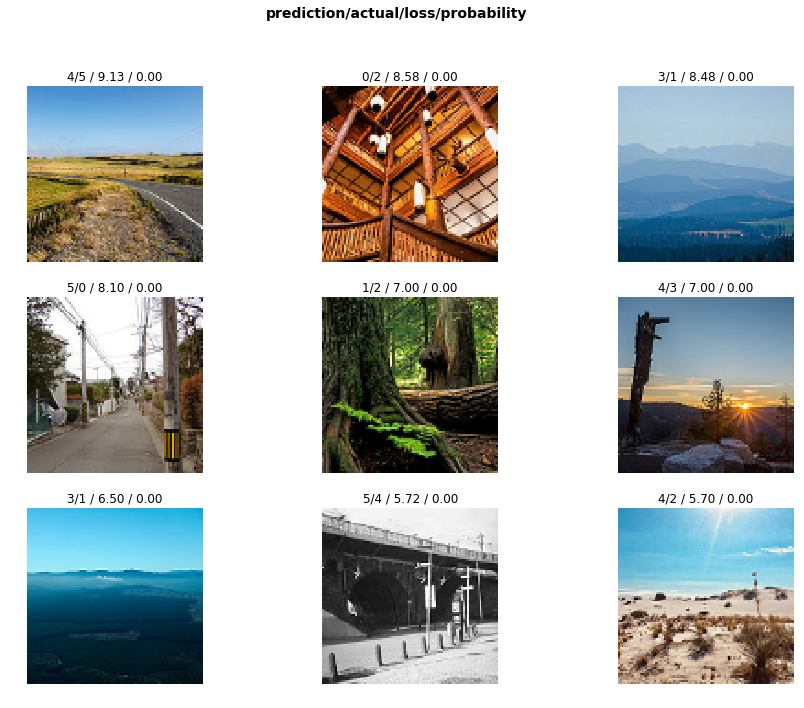

In [32]:
interp.plot_top_losses(9, figsize=(15,11))

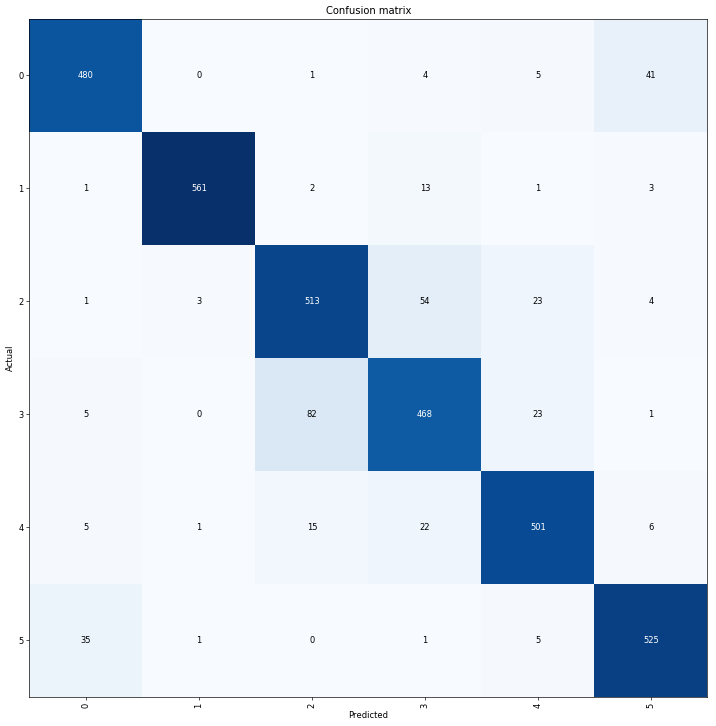

In [33]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [34]:
interp.most_confused(min_val=5)

[(3, 2, 82),
 (2, 3, 54),
 (0, 5, 41),
 (5, 0, 35),
 (2, 4, 23),
 (3, 4, 23),
 (4, 3, 22),
 (4, 2, 15),
 (1, 3, 13),
 (4, 5, 6),
 (0, 4, 5),
 (3, 0, 5),
 (4, 0, 5),
 (5, 4, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


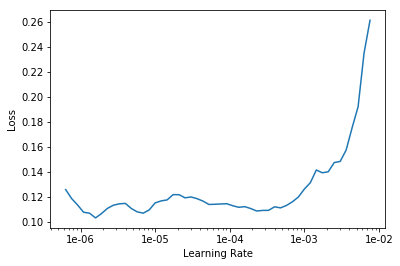

In [35]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
#learn.save('stage1-resnet152-normal')

In [36]:
import gc 
gc.collect()

6611

# Stage 3

In [37]:
learn.fit_one_cycle(9,max_lr=slice(4e-5,4e-4))

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [39]:
learn.save('stage3-resnet34-normal-rotate')

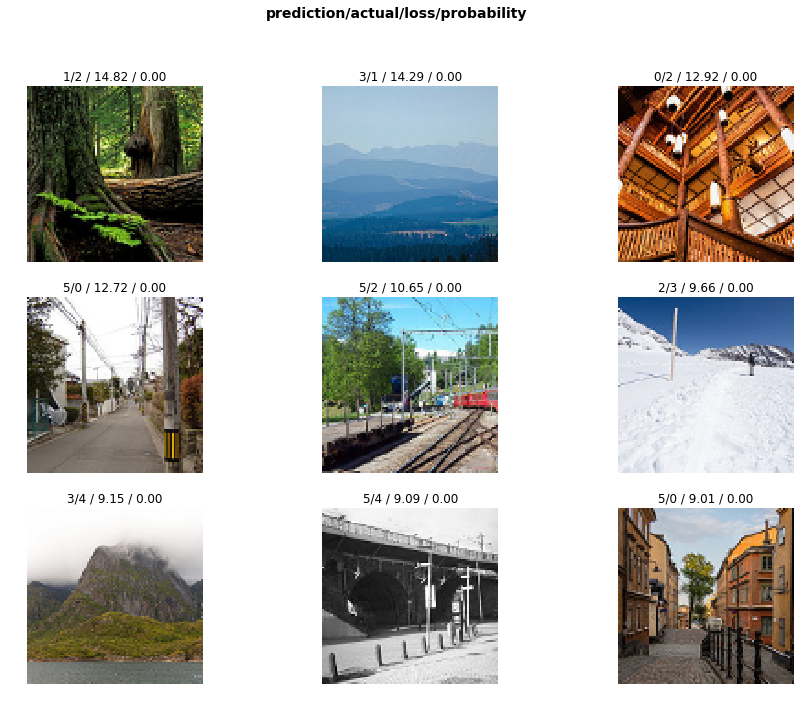

In [40]:
interp.plot_top_losses(9, figsize=(15,11))

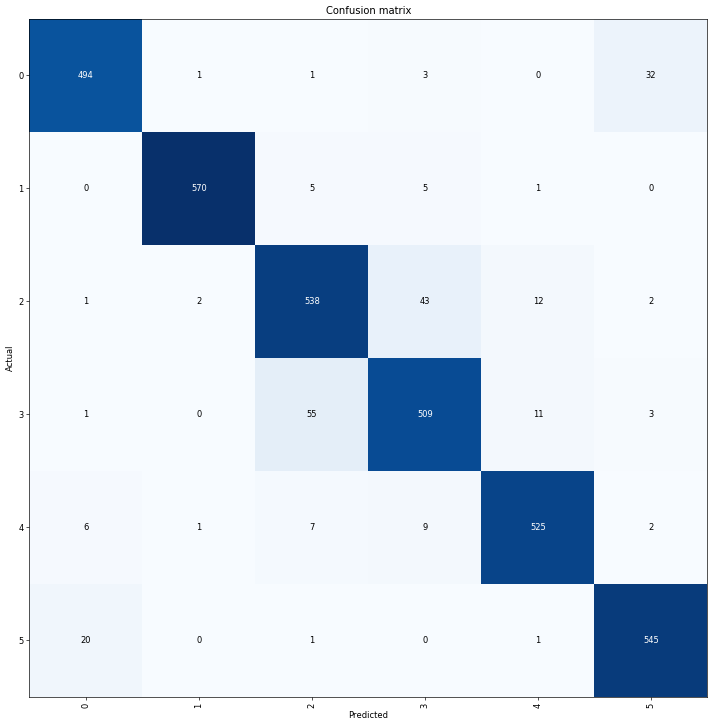

In [41]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [42]:
interp.most_confused(min_val=5)

[(3, 2, 55),
 (2, 3, 43),
 (0, 5, 32),
 (5, 0, 20),
 (2, 4, 12),
 (3, 4, 11),
 (4, 3, 9),
 (4, 2, 7),
 (4, 0, 6),
 (1, 2, 5),
 (1, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


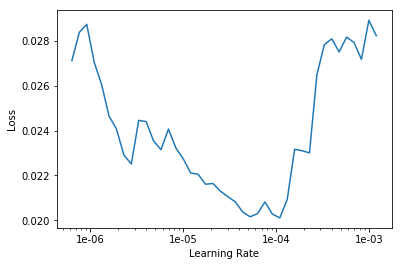

In [44]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
#learn.save('stage1-resnet152-normal')

In [43]:
import gc 
gc.collect()

18845

# Stage 4

In [45]:
learn.fit_one_cycle(9,max_lr=slice(2e-6,9e-5))

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [46]:
learn.save('stage4-resnet34-normal-rotate')

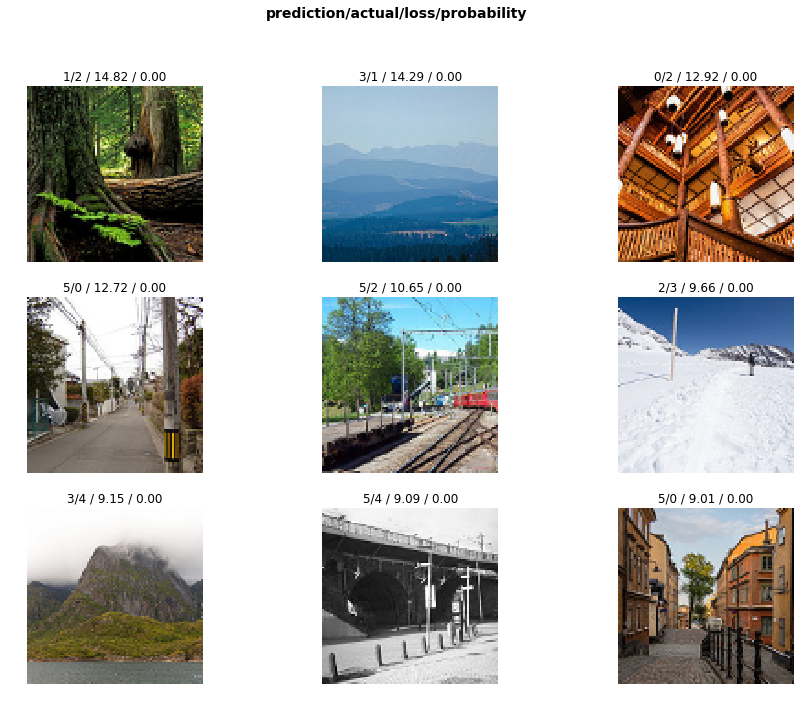

In [40]:
interp.plot_top_losses(9, figsize=(15,11))

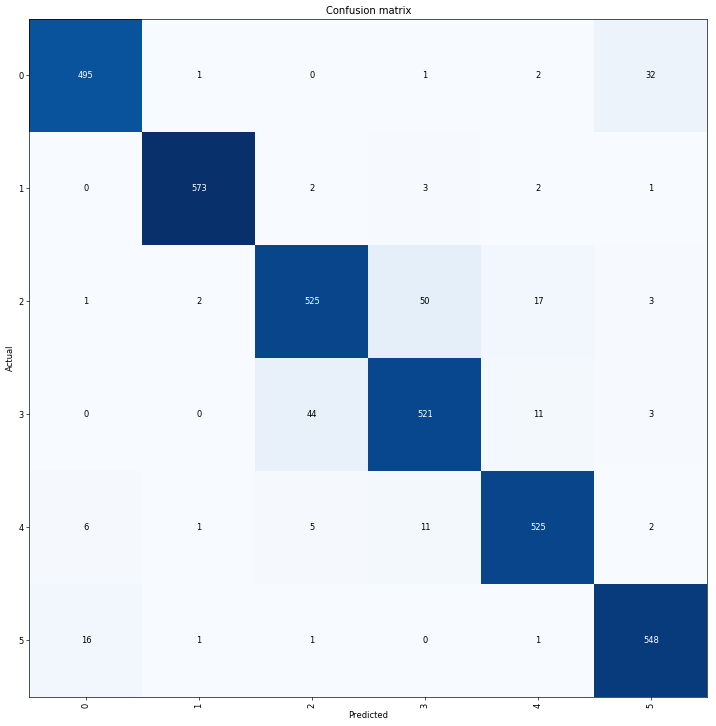

In [49]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [50]:
interp.most_confused(min_val=5)

[(2, 3, 50),
 (3, 2, 44),
 (0, 5, 32),
 (2, 4, 17),
 (5, 0, 16),
 (3, 4, 11),
 (4, 3, 11),
 (4, 0, 6),
 (4, 2, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


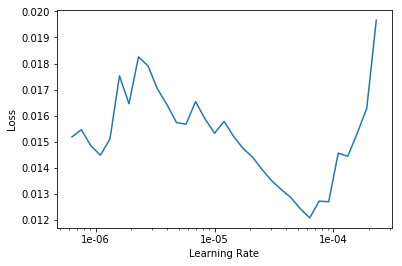

In [51]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
#learn.save('stage1-resnet152-normal')

In [48]:
import gc 
gc.collect()

5812

In [52]:
test = pd.read_csv('test.csv')

In [53]:
import gc 
gc.collect()

5507

In [54]:
path='train-scene/train'

In [55]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      5     0.999997
1      5.jpg      0     0.999971
2      6.jpg      4     0.999551
3     11.jpg      2     0.996031
4     14.jpg      5     0.999997

In [11]:
uncertain = answer.loc[answer['probability']<0.5]
print(uncertain)

     image_name  label  probability
113     393.jpg      1     0.363244
493    1634.jpg      2     0.477030
738    2483.jpg      5     0.437503
1028   3508.jpg      3     0.440011
1151   3947.jpg      2     0.390634
2162   7219.jpg      5     0.409379
2457   8135.jpg      0     0.358818
2762   9165.jpg      3     0.492966
2857   9452.jpg      1     0.443902
3230  10769.jpg      0     0.454804
3354  11175.jpg      0     0.472816
3405  11397.jpg      0     0.446411
3715  12461.jpg      4     0.499643
4009  13447.jpg      3     0.400732
4124  13807.jpg      1     0.360525
5091  17023.jpg      2     0.443777
5318  17710.jpg      2     0.439337
5391  17976.jpg      1     0.457644
5574  18616.jpg      1     0.497119
5669  18956.jpg      0     0.495491
6166  20542.jpg      3     0.391633
7058  23539.jpg      4     0.297049
7155  23839.jpg      3     0.457187


In [12]:
uncertain_count = answer.loc[answer['probability']<0.5].count()
print(uncertain_count)

image_name     23
label          23
probability    23
dtype: int64


In [13]:
answer.to_csv('stage2_resnet34_normal_rotate.csv')